In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Importar pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torch.autograd import Variable 


In [2]:
path = 'data/ConsumerFull.csv'
df = pd.read_csv(path, index_col = "Fecha", sep=',', encoding='utf-8', parse_dates=True)
columnas = df.columns  
df

,Monthly inflation,Accumulated inflation for the year,Annual inflation
Fecha,,,
1970-01-01,0.76,0.76,5.20
1970-02-01,-0.01,0.75,4.81
1970-03-01,0.29,1.04,5.01
1970-04-01,0.13,1.17,4.87
1970-05-01,0.21,1.39,5.09
...,...,...,...
2023-12-01,0.71,4.66,4.66
2024-01-01,0.89,0.89,4.88
2024-02-01,0.09,0.99,4.40


<Axes: title={'center': 'Inflación Mexicana Anual de 1970 a 2024'}, xlabel='Fecha'>

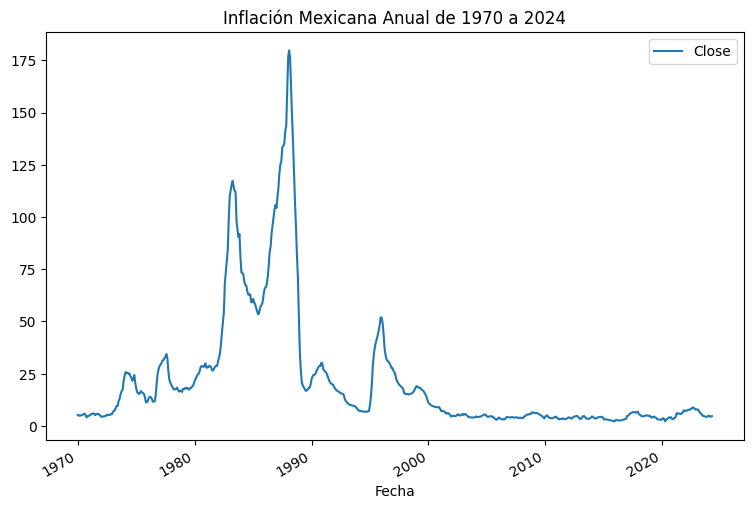

In [3]:
df.plot( 
    title= "Inflación Mexicana Anual de 1970 a 2024",
    y="Annual inflation",
    label="Close", x_compat=True, figsize=(9,6) 
)


In [4]:
"""
Los datos de entrenamiento serán de 1970-2010.
Del 2011 para arriba serán de validación
"""


split_index = "01/01/2011"
train_df = df.loc[:split_index]
test_df = df.loc[split_index:]

# print(split_index)
# print(train_df)
# print(test_df)

X_train = train_df.iloc[:, :-1]
Y_train = train_df.iloc[:, 2:3]

X_test = test_df.iloc[:, :-1]
Y_test = test_df.iloc[:, 2:3]

print(X_test)
print(Y_test)

# x_train = train_df["Monthly inflation"].values.astype(np.float32)
# y_train = train_df["Annual inflation"].values.astype(np.float32)

            Monthly inflation  Accumulated inflation for the year
Fecha                                                            
2011-01-01               0.49                                0.49
2011-02-01               0.38                                0.86
2011-03-01               0.19                                1.06
2011-04-01              -0.01                                1.05
2011-05-01              -0.74                                0.30
...                       ...                                 ...
2023-12-01               0.71                                4.66
2024-01-01               0.89                                0.89
2024-02-01               0.09                                0.99
2024-03-01               0.29                                1.28
2024-04-01               0.20                                1.48

[160 rows x 2 columns]
            Annual inflation
Fecha                       
2011-01-01              3.78
2011-02-01              3.57
20

In [5]:
"""
Normalizamos los datos
"""
min_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

#Conjunto de entrenamiento
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.fit_transform(X_test)

#Conjunto de prueba
Y_train_scaled = min_scaler.fit_transform(Y_train)
Y_test_scaled = min_scaler.fit_transform(Y_test)


In [6]:
#Object Varibale Computes and returns the sum of gradients of outputs with respect to the inputs.
X_train_tensor = Variable(
    torch.Tensor(X_train_scaled)
)
Y_train_tensor = Variable(
    torch.Tensor(Y_train_scaled)
)

X_test_tensor = Variable(
    torch.Tensor(X_test_scaled)
)
Y_test_tensor = Variable(
    torch.Tensor(Y_test_scaled)
)



X_train_tensor = torch.reshape(
    X_train_tensor,
    ( X_train_tensor.shape[0], 1, X_train_tensor.shape[1] )
)

X_test_tensor = torch.reshape(
    X_test_tensor,
    ( X_test_tensor.shape[0], 1, X_test_tensor.shape[1] )
)


In [7]:
def entrena_red(red, X, Y, epochs, criterion, optimizer):
    for epoch in range(epochs):
        
        outputs = red.forward( X ) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
        
        # obtain the loss function
        loss = criterion(outputs, Y)
        
        loss.backward() #calculates the loss of the loss function
        
        optimizer.step() #improve from loss, i.e backprop

        red.error_history.append(loss.item())

        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [8]:
def print_error_plot(historial):
    #plt.figure()
    plt.plot(historial)
    plt.title("Progreso del error")
    plt.xlabel("Iteración")
    plt.ylabel("Error")
    plt.show()

In [9]:
def imprime_prediccion( titulo, Real, Estimada):
    plt.figure(figsize=(10,6)) #plotting

    plt.plot(Real, label='Inflación Actual') #actual plot
    plt.plot(Estimada, label='Inflación Estimada') #predicted plot
    plt.title(titulo)
    plt.legend()
    plt.show() 

## Radial Basis Neural Network
Radial Basis Function (RBF) neural network is an upgrade of multilayer perceptron network (MLP). The name comes from the name of its activation function. Generally, RBF is any real-valued function whose values depend
only on the distance from the origin or from some other point c, called a center. Any function I that satisfies this property is a radial function. The norm is usually Euclidean distance. Moreover, before providing predictions, the
neural network of the RBF type must be adapted to approximate the data. Hence, the function defined in Eq. 1 must be minima

In [10]:
# Radial basis neural network

class RadialBasisNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RadialBasisNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        self.capa_1 = nn.Linear(input_size, hidden_size)
        self.capa_2 = nn.Linear(hidden_size, output_size)
        self.capa_3 = nn.Linear(hidden_size, 1)

        self.error_history = []

    def forward(self, x):
        out = self.capa_1(x)
        out = torch.tanh(out)
        out = self.capa_2(out)
        return out

In [11]:
# Entrenamiento de la red
def entrena_red_rbf(red, X, Y, epochs, criterion, optimizer):
    for epoch in range(epochs):
        outputs = red.forward(X)
        optimizer.zero_grad()
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        red.error_history.append(loss.item())
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

num_epochs = 1000
learning_rate = 0.001
input_size = 2

red_rbf = RadialBasisNeuralNetwork(input_size, 128, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(red_rbf.parameters(), lr=learning_rate)

X_train_tensor = Variable(torch.Tensor(X_train_scaled))
Y_train_tensor = Variable(torch.Tensor(Y_train_scaled))

entrena_red_rbf(red_rbf, X_train_tensor, Y_train_tensor, num_epochs, criterion, optimizer)

Epoch: 0, loss: 0.07643
Epoch: 100, loss: 0.00831
Epoch: 200, loss: 0.00764
Epoch: 300, loss: 0.00737
Epoch: 400, loss: 0.00719
Epoch: 500, loss: 0.00704
Epoch: 600, loss: 0.00690
Epoch: 700, loss: 0.00679
Epoch: 800, loss: 0.00671
Epoch: 900, loss: 0.00666


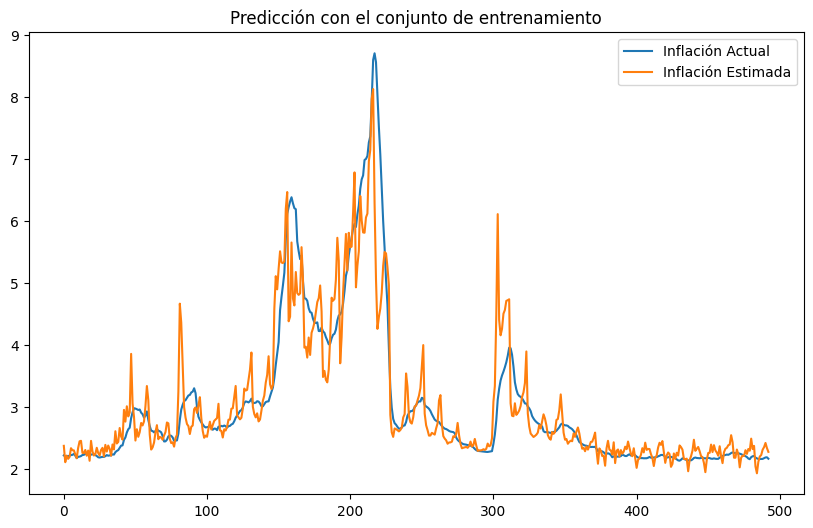

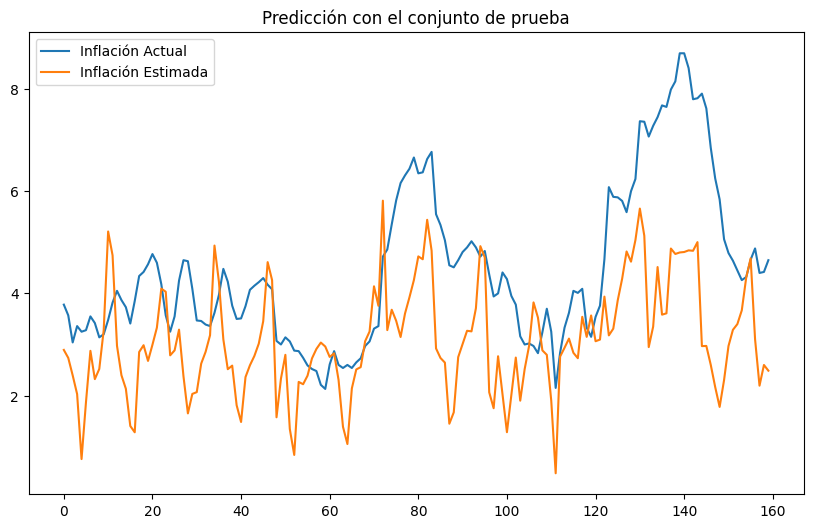

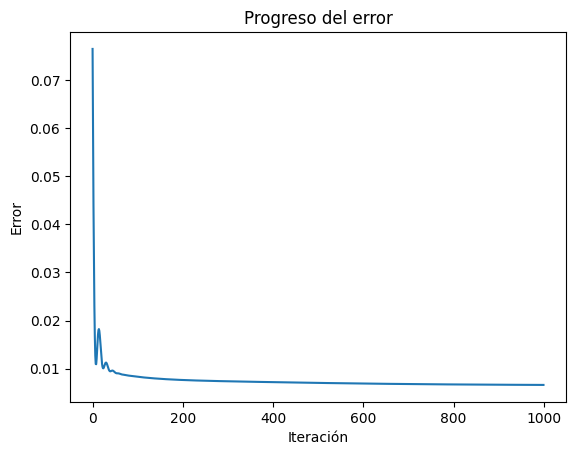

In [12]:
# Predicción con los datos de entrenamiento
training_net_output = red_rbf(X_train_tensor)
output_data = training_net_output.data.numpy()

output_reScaled = min_scaler.inverse_transform(output_data)
Y_data = Y_train_tensor.data.numpy()
Y_reScaled = min_scaler.inverse_transform(Y_data)

imprime_prediccion(
    'Predicción con el conjunto de entrenamiento',
    Y_reScaled,
    output_reScaled
)

# Predicción con los datos de prueba
X_test_tensor = Variable(torch.Tensor(X_test_scaled))
Y_test_tensor = Variable(torch.Tensor(Y_test_scaled))

test_net_output = red_rbf(X_test_tensor)
output_data = test_net_output.data.numpy()

output_reScaled = min_scaler.inverse_transform(output_data)
Y_data = Y_test_tensor.data.numpy()
Y_reScaled = min_scaler.inverse_transform(Y_data)

imprime_prediccion(
    'Predicción con el conjunto de prueba',
    Y_reScaled,
    output_reScaled
)

print_error_plot(red_rbf.error_history)